#News Category Dataset
##Identify the type of news based on headlines and short descriptions

## Context

This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost.

[More details](https://www.kaggle.com/rmisra/news-category-dataset)

In [0]:
import pandas as pd
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
raw_df = pd.read_json('/content/gdrive/My Drive/Colab Notebooks/News_Category_Dataset_v2.json', lines = True)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Exploarative data analysis

In [3]:
raw_df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [4]:
raw_df.isnull().sum()

authors              0
category             0
date                 0
headline             0
link                 0
short_description    0
dtype: int64

In [5]:
print('Number of categories: ', len(raw_df.category.unique()))

Number of categories:  41


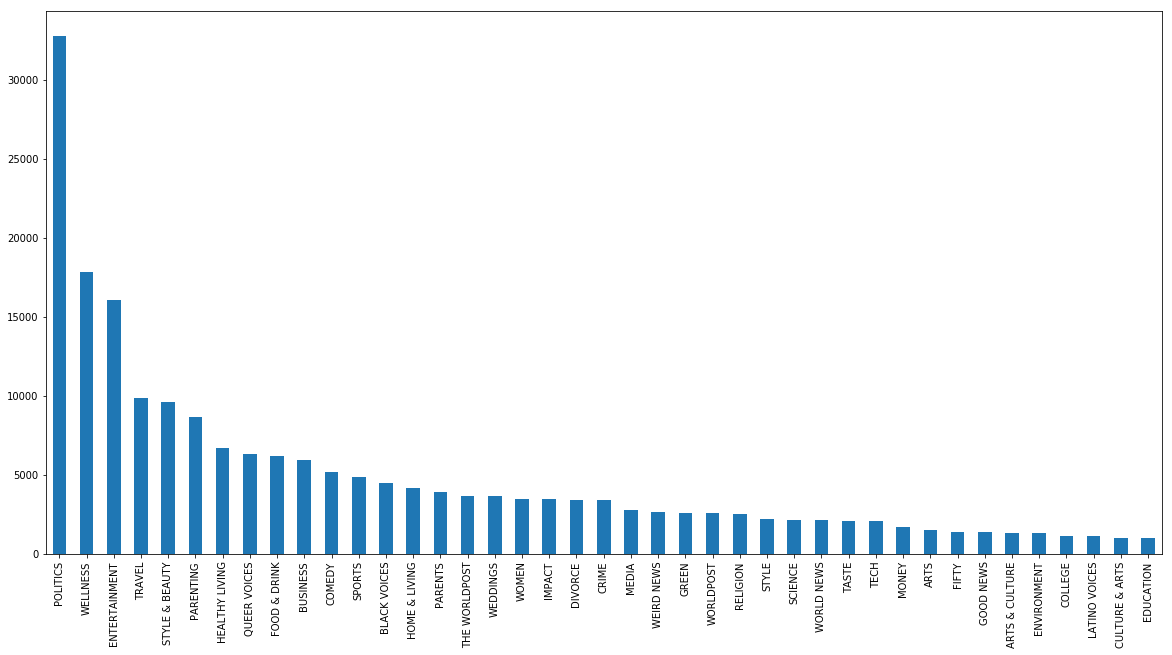

In [6]:
pd.value_counts(raw_df.category).plot(figsize=(20,10), kind='bar')

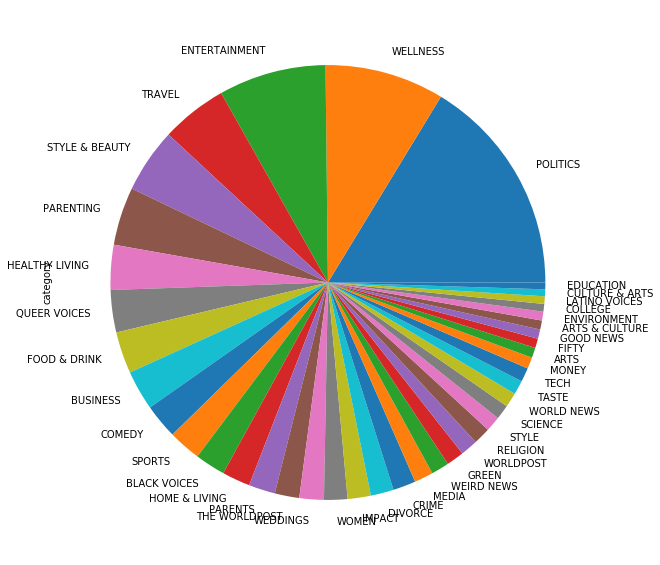

In [7]:
pd.value_counts(raw_df.category).plot(figsize=(10,10), kind='pie')

In [8]:
print('Number of rows without short description: ', sum(raw_df.short_description == ''))

Number of rows without short description:  19712


In [9]:
print('Number of rows without headline: ', sum(raw_df.headline == ''))

Number of rows without headline:  6


In [10]:
#Only use data contain headline or short description
df = raw_df[(raw_df.headline != '') | (raw_df.short_description != '')][['category', 'headline', 'short_description']]
#Combine headline and short description
df['text'] = df.headline + ' \n ' + df.short_description
df = df[['text', 'category']]
print('Size of dataset: ', df.shape)

Size of dataset:  (200848, 2)


We use English letters only to train our model and make prediction


In [11]:
letters_only = lambda x: re.sub('[^a-zA-Z]', ' ', x)
df.text = df.text.apply(letters_only)
df.head()

,text,category
0,There Were Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The ...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age ...,ENTERTAINMENT
3,Jim Carrey Blasts Castrato Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [0]:
# from tf.keras.preprocessing.sequence import pad_sequences
MAXLEN = 100
catg_index = dict(enumerate([i for i in pd.value_counts(df.category).index]))
catg_index = {v: k for k,v in catg_index.items()}
index_catg = {v: k for k, v in catg_index.items()}
df['category_index'] = df.category.apply(lambda x: catg_index.get(x))

##Data preparation for model training

<font size="4">Tokenization</font>**bold text**

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.text)
df['word_index'] = tokenizer.texts_to_sequences(df.text)

In [14]:
df.head()

,text,category,category_index,word_index
0,There Were Mass Shootings In Texas Last Week...,CRIME,20,"[60, 106, 1271, 2909, 7, 646, 136, 92, 29, 121..."
1,Will Smith Joins Diplo And Nicky Jam For The ...,ENTERTAINMENT,2,"[45, 1392, 2910, 22678, 5, 23907, 4951, 9, 1, ..."
2,Hugh Grant Marries For The First Time At Age ...,ENTERTAINMENT,2,"[5777, 4982, 7722, 9, 1, 81, 56, 23, 401, 1, 8..."
3,Jim Carrey Blasts Castrato Adam Schiff And D...,ENTERTAINMENT,2,"[2595, 10635, 3514, 52932, 2230, 12303, 5, 521..."
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,2,"[36118, 29453, 1484, 101, 35, 7339, 3073, 2, 9..."


<font size="4">**We only predict top 10 most frequently occurring news categories for the reasons of shorter training time and better performance.**
</font>


In [0]:
df_subset = df[df.category_index < 10]

In [0]:
PADDING = 'pre'
TRUNCATING = 'post'
def get_sequence(DF, padding, truncating):
    X = DF.word_index
    y = DF.category_index
    X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAXLEN, padding=padding, truncating=truncating)
    return X, y
X, y = get_sequence(df_subset, PADDING, TRUNCATING)

In [0]:
RANDOM_SEED = 10
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.33, random_state=RANDOM_SEED)


In [0]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [0]:
word2index = tokenizer.word_index
index2word = {v: k for k, v in word2index.items()}

<font size="4">Word embedding using GloVe 100-Dimensional Word Vectors</font>

In [20]:
embeddings_index = {}
glove_dir = '/content/gdrive/My Drive/Colab Notebooks/glove.6B'
f = open(glove_dir +'/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word2index) + 1, EMBEDDING_DIM))
unknown = []
known = []
for word, i in word2index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        known.append(word)
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        unknown.append(word)

In [22]:
print('Number of words in the dataset not found in the embedding index:\t', len(unknown))
print('Number of words in the dataset found in the embedding index:\t\t',len(known))
print('Number of unique words in the dataset:\t\t\t\t\t', len(word2index))

Number of words in the dataset not found in the embedding index:	 14098
Number of words in the dataset found in the embedding index:		 70367
Number of unique words in the dataset:					 84465


In [23]:
embedding_matrix.shape

(84466, 100)

In [0]:
MAX_SEQUENCE_LENGTH = MAXLEN #max(df.words.apply(len))
BIDIRECIONAL = True
EMBED_DIM = 100
EMBED_DROPOUT = 0
DROPOUT = 0.2
RECURRENT_DROPOUT = 0.2
LSTM_OUT_DIM = 50
BATCH_SIZE = 128
NUM_EPOCH = 20
SEQ_OUT = False
NUM_CATG = 10
REG_COEF = 0.01


##Model building and training

<font size="4">Bidirectional  LSTM</font>

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word2index) + 1,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix],
                              input_length = MAX_SEQUENCE_LENGTH, 
                              trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_OUT_DIM, 
                                                       dropout=DROPOUT, 
                                                       recurrent_dropout=RECURRENT_DROPOUT,
                                                       kernel_regularizer=tf.keras.regularizers.l2(REG_COEF),
                                                       bias_regularizer=tf.keras.regularizers.l2(REG_COEF),
                                                       return_sequences=SEQ_OUT)),
#     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(NUM_CATG)),
    tf.keras.layers.Dense(NUM_CATG),
    tf.keras.layers.Activation('softmax'),

    ]
)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          8446600   
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 8,508,010
Trainable params: 8,508,010
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
%%time
filepath="./news_weights_best.h5"

mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath, 
                           monitor='val_categorical_accuracy', 
                           verbose=1, 
                           save_best_only=True, 
                           save_weights_only=False, 
                           mode='max', 
                           period=1)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                              min_delta=0, 
                              patience=5, 
                              verbose=1, 
                              mode='auto', 
                              baseline=None, 
                              restore_best_weights=False)

reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                   factor=0.1, 
                                   patience=2, 
                                   verbose=1, 
                                   mode='min', 
                                   min_delta=0.0001, 
                                   cooldown=0, 
                                   min_lr=0)

history = model.fit(X_train,  y_train , 
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCH, verbose=1,
                    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
                    validation_data=(X_val, y_val)
                   )

Train on 84003 samples, validate on 24121 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
83968/84003 [============================>.] - ETA: 0s - loss: 2.0993 - categorical_accuracy: 0.5929
Epoch 00001: val_categorical_accuracy improved from -inf to 0.76875, saving model to ./news_weights_best.h5
84003/84003 [==============================] - 531s 6ms/sample - loss: 2.0989 - categorical_accuracy: 0.5930 - val_loss: 1.1065 - val_categorical_accuracy: 0.7687
Epoch 2/20
83968/84003 [============================>.] - ETA: 0s - loss: 0.9339 - categorical_accuracy: 0.7753
Epoch 00002: val_categorical_accuracy improved from 0.76875 to 0.80411, saving model to ./news_weights_best.h5
84003/84003 [==============================] - 524s 6ms/sample - loss: 0.9337 - categorical_accuracy: 0.7753 - val_loss: 0.7558 - val_categorical_accuracy: 0.8041
Epoch 3/20
83968/84003 [============================>.] - ETA: 0s - loss: 0.6867 - categorical_accuracy: 0.8183
Epoch 00003: val_cate

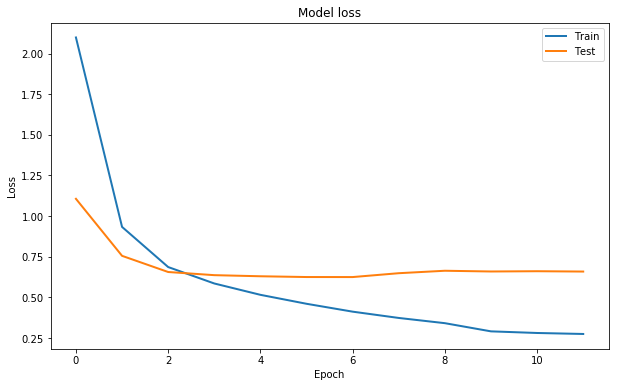

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

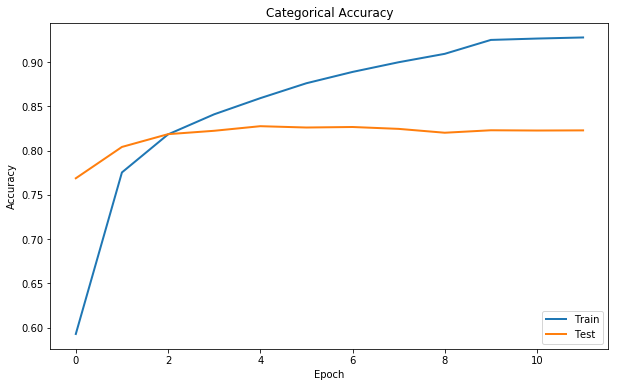

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['categorical_accuracy'], linewidth=2, label='Train')
plt.plot(history.history['val_categorical_accuracy'], linewidth=2, label='Test')
plt.legend(loc='lower right')
plt.title('Categorical Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [0]:
model_best = tf.keras.models.load_model(filepath)

##Model evaluation and prediction

In [30]:
scores = model_best.evaluate(X_test, y_test, batch_size=128, verbose=1)
print(dict(zip(model_best.metrics_names, scores)))

11881/11881 [==============================] - 13s 1ms/sample - loss: 0.6405 - categorical_accuracy: 0.8238
{'loss': 0.640532102225435, 'categorical_accuracy': 0.8237522}


In [31]:
#For the 10 random samples in the test dataset
amount_of_samples = 10
indices = np.random.choice(X_test.shape[0], amount_of_samples, replace=False)
pred = model_best.predict_classes(X_test[indices].reshape(-1, X_test.shape[1]))
print('Predictions:\t', pred)
print('True classes:\t', np.where(y_test[indices] ==1)[1])

Predictions:	 [6 0 1 4 0 1 4 1 9 0]
True classes:	 [6 0 1 4 0 1 4 1 9 0]


In [32]:
for idx, x_test in enumerate(X_test[indices]):
  words = [index2word.get(num) for num in x_test]
  words = [word for word in words if word != None]
  string = ' '.join(words)
  print(string)
  pred = model_best.predict_classes(x_test.reshape(-1, X_test.shape[1]))[0]
  label = np.where(y_test[idx] == 1)[0][0]
  print('Prediction:\t', index_catg[pred])
  print('True class:\t', index_catg[label])
  print('\n')

workaholic rules for staying out of the emergency room
Prediction:	 HEALTHY LIVING
True class:	 TRAVEL


republican congressman runs ad saying he doesn t like donald trump he doesn t like hillary clinton either
Prediction:	 POLITICS
True class:	 TRAVEL


ways meditation makes you kinder we open our heart to ourselves with tenderness seeing ourselves just as we are maybe for the first time opening with a heart as big as the universe in the same way we open to all others seeing them just as they are without likes or dislikes prejudicing our view
Prediction:	 WELLNESS
True class:	 POLITICS


michelle obama scarlett johansson wear preen in the same week photos rumors recently flew that flotus had banned scarlett and fellow actress kerry washington from the white house for being flirty
Prediction:	 STYLE & BEAUTY
True class:	 STYLE & BEAUTY


john boehner calls harry reid s idea nutso
Prediction:	 POLITICS
True class:	 ENTERTAINMENT


reunion with soul launching love through your gps never 